# Test Point in Time Model M1

In [1]:
import torch as torch
from torch.utils.data import *
import torch.nn.functional as F
import numpy as np
from os import path
from pitM1model import *
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TEST_PATH = '/home/user/notebooks/data/test'
MODEL_PATH = '/home/user/notebooks/data/model/pitM1/20190825_222822'
MODEL_SAVED = MODEL_PATH + '/pitM1.pth'

## Plot Loss Curves

In [3]:
checkpoint = torch.load(MODEL_SAVED)

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

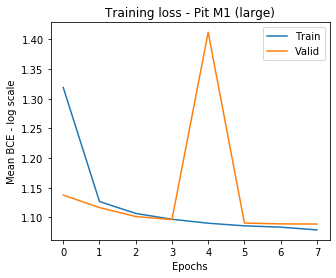

In [107]:
plt.figure(1, figsize=[5, 4])
plt.plot(checkpoint['train_losses'], label='Train')
plt.plot(checkpoint['valid_losses'], label='Valid')
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.legend(loc='best') 
plt.title('Training loss - Pit M1 (large)')
plt.savefig(MODEL_PATH+'/training_loss.png', dpi=200)

## Test Data

In [7]:
t_acq, t_idx_to_seq, t_seq, t_macros, t_ym2idx = load_data(TEST_PATH, True, False)

Loading: /home/user/notebooks/data/test/fnm_input_seq_0.90.npy:   0%|          | 0/5 [00:00<?, ?it/s]

Acquisition: /home/user/notebooks/data/test/fnm_input_acq.npy
Sequence: /home/user/notebooks/data/test/fnm_input_seq_*.npy
Index to Sequence Index: /home/user/notebooks/data/test/fnm_input_idx_to_seq.npy
Macros: /home/user/notebooks/data/test/fred_norm.npy
YYYYMM to Index: /home/user/notebooks/data/test/ym2idx.pickle
loading seq_chunk


Loading: /home/user/notebooks/data/test/fnm_input_seq_0.98.npy: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


In [8]:
BATCH_SIZE = 256 
NUM_WORKERS = 4
LOSS_EVERY_N_BATCHES=100
SAVE_EVERY_N_BATCHES=1000

In [9]:
test_ds = FNMMacrosDataset(t_acq, t_idx_to_seq, t_seq, t_macros, t_ym2idx, 12, 0)

Initial acq: 2,541,605
Non-short acq: 2,541,159


In [10]:
testDL = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle = True, \
        collate_fn=paddingCollator, num_workers=NUM_WORKERS, pin_memory=True)

In [11]:
model_params = {
    'seq_n_features': 39, # seq + macros
    'lstm_size': 600,
    'lstm_layers': 3,
    'lstm_dropout': 0.2,
    'emb_acq_dims' : [(55, 25), # state id
                      (5, 2), # purpose_id
                      (4, 2), # mi_type_id
                      (4, 2), # occupancy_status_id
                      (2, 2), # product_type_id
                      (6, 2), # property_type_id
                      (95, 40), # seller_id
                      (1001, 50)], # zip3
    'emb_seq_dims' : [(219, 50), # yyyymm
                      (407, 50), #msa
                      (46, 23)] # servicer
}

In [12]:
model = makeModel(model_params)
loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=model.parameters())

In [13]:
fitCtx = TrainingContext(
    MODEL_SAVED, 
    model, 
    loss_function, 
    optimizer, 
    testDL, 
    testDL,
    SAVE_EVERY_N_BATCHES,
    LOSS_EVERY_N_BATCHES
)

fitCtx.useGPU(True)
checkpoint_epoch = fitCtx.loadModel()
fitCtx.makeParallel(True)

Using device: cuda
Loading model checkpoint: /home/user/notebooks/data/model/pitM1/20190825_222822/pitM1.pth
Training on 2 GPUs


In [14]:
target_vec = np.zeros((len(test_ds), 12), dtype=np.int32)
target_hat_mat = np.zeros((len(test_ds), 19, 12), dtype=np.float32)
last_dlq = -1*np.ones((len(test_ds)))
losses = []

In [15]:
fitCtx.model.eval()
with torch.no_grad():
    for bidx, (seq, seq_len, ymd, acq, target) in enumerate(tqdm(testDL)):
        #tq.set_description('Test: %i' % bidx)
        
        target_vec[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :] = target.detach().cpu().numpy()
        last_dlq[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE] = np.argmax(seq[:, -1, -19:].detach().cpu().numpy())

        target_hat = fitCtx.model(seq, seq_len, ymd, acq)
        target = target.to(target_hat.device)
        loss = loss_function(target_hat, target)
        losses.append(loss.item())
        
        target_hat = F.softmax(target_hat, dim=1)
        target_hat_mat[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :, :] = target_hat.detach().cpu().numpy()

100%|██████████| 9927/9927 [07:37<00:00, 21.68it/s]


In [16]:
test_loss = np.mean(losses)/testDL.batch_size

In [17]:
test_loss

2.0645354839881116

## Build ROC Curve

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Calculate corresponding 1 year default rate

In [19]:
dlq_predicted = np.argmax(target_hat_mat, axis=1)
defaults_predicted = 1*(np.max(dlq_predicted, axis=1) > 6)

In [20]:
def_score = np.sum(target_hat_mat[:, 7:, :], axis=1)

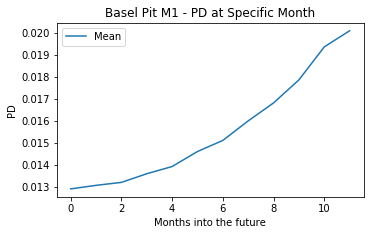

In [155]:
plt.figure(1, figsize=[5.5, 3.2])
plt.plot(np.mean(def_score, axis=0), label='Mean')
plt.xlabel('Months into the future')
plt.ylabel('PD')
plt.title('Basel Pit M1 - PD at Specific Month')
plt.legend(loc='best') 
plt.savefig(MODEL_PATH+'/mean_pd.png', dpi=100)

In [22]:
def1y_score = 1-np.prod(1-def_score, axis=1)
def1y_target = 1*(np.max(target_vec, axis=1) >= 7)

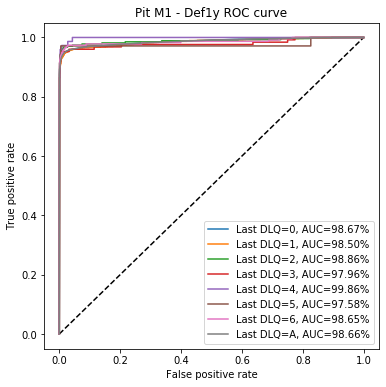

In [115]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(1, figsize=[6, 6])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(7):
    idx = np.where(last_dlq==dlq)
    fpr[dlq], tpr[dlq], _ = roc_curve(def1y_target[idx], def1y_score[idx])
    roc_auc[dlq] = auc(fpr[dlq], tpr[dlq])
    plt.plot(fpr[dlq], tpr[dlq], label='Last DLQ={}, AUC={:.2f}%'.format(dlq, roc_auc[dlq]*100))
fpr[-1], tpr[-1], _ = roc_curve(def1y_target, def1y_score)
roc_auc[-1] = auc(fpr[-1], tpr[-1])
plt.plot(fpr[-1], tpr[-1], label='Last DLQ=A, AUC={:.2f}%'.format(roc_auc[-1]*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Pit M1 - Def1y ROC curve')
plt.legend(loc='best')
plt.savefig(MODEL_PATH+'/def1y_roc.png', dpi=200)

## Build Multiclass ROC

In [ ]:
#target_vec = np.zeros((len(test_ds), 12), dtype=np.int32)
#target_hat_mat = np.zeros((len(test_ds), 19, 12), dtype=np.float32)
#last_dlq = -1*np.ones((len(test_ds)))

In [147]:
np.unique(target_vec[dlq_idx, t])

array([0], dtype=int32)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


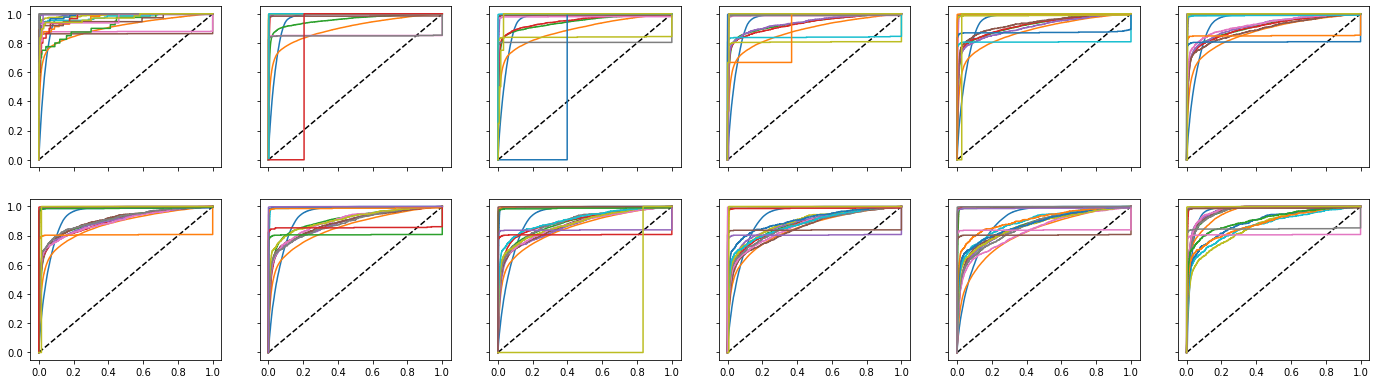

In [150]:
t = 0
fig, ax = plt.subplots(2, 6, sharex='col', sharey='row')
fig.set_size_inches(24, 6.5)
for i in range(2):
    for j in range(6):
        ax[i, j].plot([0, 1], [0, 1], 'k--')
        for q in range(0, 19):
            dlq_label = 1*(target_vec[:, t]==q)
            fpr, tpr, _ = roc_curve(dlq_label, target_hat_mat[:, q, t])
            roc_auc = auc(fpr, tpr)
            ax[i, j].plot(fpr, tpr, label='DLQ={}, AUC={:.2f}%'.format(dlq, roc_auc*100))
            ax[i, j].text()
        t += 1

In [162]:
np.where((target_vec[:, 2]==1) * (target_vec[:, 8]==7))

(array([   1821,    9759,   10798,   23275,   23584,   30350,   43456,
          72350,   94908,  112393,  142499,  145074,  149660,  158015,
         168418,  210556,  213048,  226329,  237489,  238688,  248371,
         250112,  252071,  267345,  268411,  271886,  272828,  289802,
         297081,  309766,  311224,  313534,  344564,  348011,  390977,
         392621,  403294,  403971,  409337,  433941,  440179,  442881,
         444727,  451044,  452958,  465552,  472203,  490513,  498700,
         500263,  527888,  528192,  531081,  558632,  579502,  587832,
         588571,  608871,  620128,  627018,  629496,  631928,  634159,
         637292,  681950,  694080,  735988,  754458,  756515,  757738,
         779243,  780433,  781204,  784804,  788224,  791564,  818805,
         827207,  830051,  854462,  855488,  868610,  874640,  878920,
         879355,  884786,  890092,  894644,  894793,  895477,  932875,
         951063,  963512,  968201,  992525,  999055, 1027028, 1040390,
      

In [225]:
np.where((np.argmax(target_hat_mat[:, :, 6], axis=1)>6) * (np.argmax(target_hat_mat[:, :, 1], axis=1)==1)* (np.argmax(target_hat_mat[:, :, 2], axis=1)==2))

(array([1891701]),)

In [227]:
last_dlq[1891701]

0.0

In [226]:
np.savetxt("target_hat_mat_1891701.csv", target_hat_mat[1891701, :, :], delimiter=",")

## Embeddings

### Embedded YYYYMM

In [32]:
import pandas as pd
date_start = '2000-01-01'
date_end = '2018-03-01'
dr = pd.date_range(date_start, date_end, freq='MS')

In [33]:
dr.strftime('%Y%m').astype(str)[0]

'200001'

In [34]:
model.emb_seq[0]

Embedding(219, 50)

In [35]:
yyyymm_idx = model.emb_seq[0](torch.arange(0,219).cuda()).detach().cpu().numpy()

<Figure size 1296x1296 with 0 Axes>

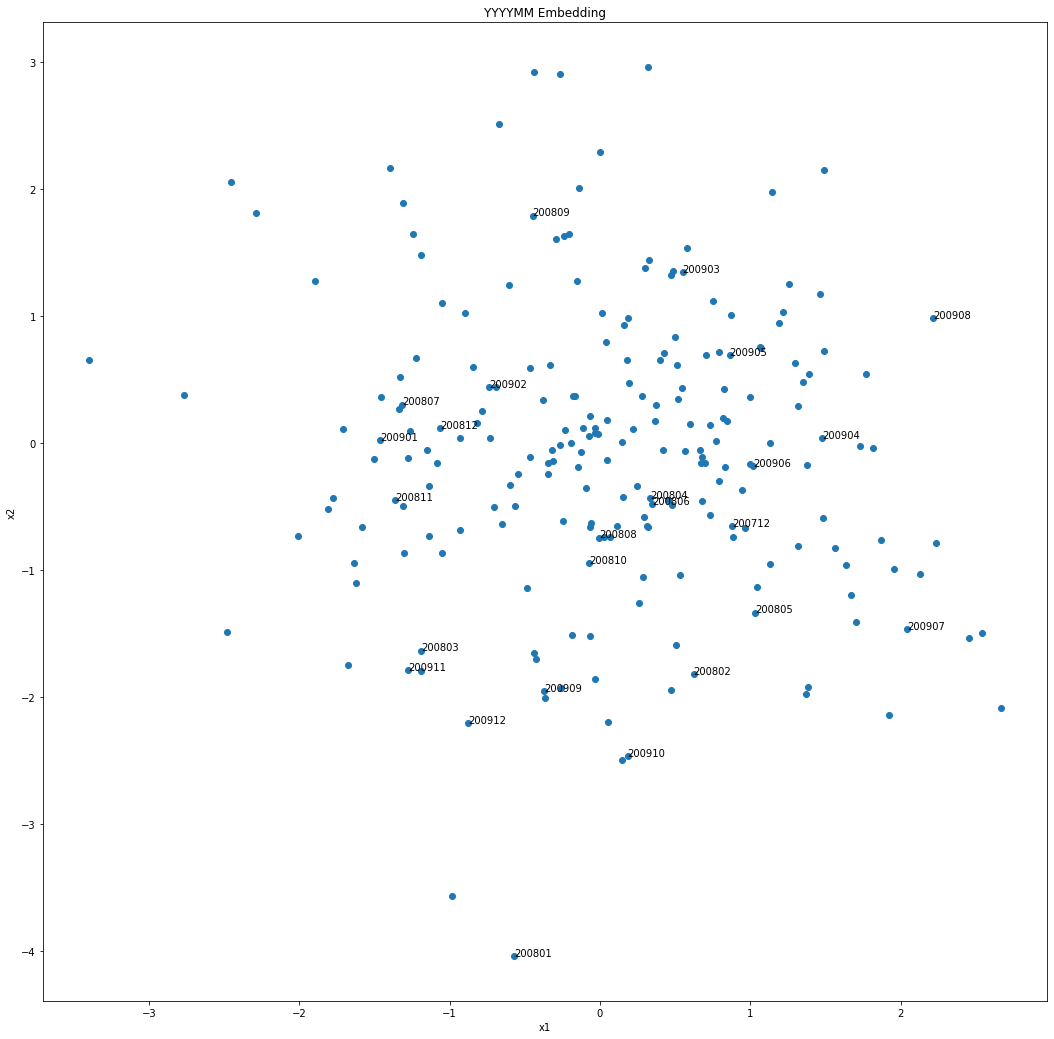

In [36]:
plt.figure(1, figsize=[18, 18])
fig, ax = plt.subplots(figsize=[18, 18])
ax.scatter(yyyymm_idx[:, 0], yyyymm_idx[:, 1])

for i, yyyymm_str in enumerate(dr.strftime('%Y%m').astype(int)):
    if 200712 <= yyyymm_str and yyyymm_str <= 200912:
        ax.annotate(yyyymm_str, (yyyymm_idx[i, 0], yyyymm_idx[i, 1]))
plt.xlabel("x1")
plt.ylabel('x2')
plt.title('YYYYMM Embedding')
plt.savefig(MODEL_PATH+'/yyyymm_embedding.png', dpi=200)

### Construct Embedding Using TensorBoard

In [92]:
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

In [98]:
writer = SummaryWriter('/home/user/notebooks/data/model/pitM1/20190825_222822/runs')

**YYYYMM Embedding**

In [94]:
date_start = '2000-01-01'
date_end = '2018-03-01'
dr = pd.date_range(date_start, date_end, freq='MS')
drint = dr.strftime('%Y%m').astype(int)
drstr = dr.strftime('%Y-%m-%d').astype(str)
label_img = torch.zeros(yyyymm_idx.shape[0], 3, 30, 30)
label_img[:, 2, :, :] = 1
label_img[(200907 <= drint)*(drint <= 201111), 0, :, :] = 1
writer.add_embedding(yyyymm_idx, metadata=drstr, label_img=label_img, global_step=1, tag='default', metadata_header=None)

In [97]:
writer.flush()
writer.close()